# Devils DFTD 2-Stage Infection

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../')))

In [2]:
import time
import json
import pickle

In [3]:
from gillespy2 import TauHybridCSolver, cleanup_tempfiles

In [4]:
from dask.distributed import Client
from dask import delayed

In [5]:
from Devils_DFTD_2_Stage_Infection import DevilsDFTD2StageInfection
from Simulation import Simulation, devil_pop
from ParameterSweep import ParameterSweep

In [6]:
c = Client(n_workers=8, threads_per_worker=1)

## With Vaccination Intervention
### Load existing state

In [7]:
vacc_state_path = "../ParameterSweeps/DevilsDFTD2StageInfectionWithVaccinationState.p"
if os.path.exists(vacc_state_path):
    with open(vacc_state_path, "rb") as vacc_state_file:
        vacc_state = pickle.load(vacc_state_file)
        
    # Model
    vacc_model = vacc_state['model']
    # Simulation
    vacc_sim = Simulation.load_state(vacc_state['sim'])
    # Parameter Sweep Job
    vacc_job = ParameterSweep.load_state(vacc_state['job'], batch_size=150, statefile=vacc_state_path)
else:
    vacc_state = None
    print("No existing vaccination state found.")

    # Model
    vacc_model = DevilsDFTD2StageInfection(devil_pop, interventions="vaccination")
    # Simulation
    vacc_sim = Simulation(model=vacc_model)
    # Parameter Sweep Job
    vacc_job = ParameterSweep(model=vacc_model, batch_size=150, statefile=vacc_state_path)

### Solver

In [8]:
vacc_sol = delayed(TauHybridCSolver)(model=vacc_model, variable=True, delete_directory=False)

### Simulation

In [9]:
vacc_sim.configure(solver=vacc_sol)
%time _ = vacc_sim.run(use_existing_results=True)

CPU times: user 4 µs, sys: 5 µs, total: 9 µs
Wall time: 10.7 µs


In [10]:
vacc_sim.output_dftd_devils_probs(print_probs=True)

DFTD elimination: 0%
Devil extinction: 0%


### Visualize Simulation Results

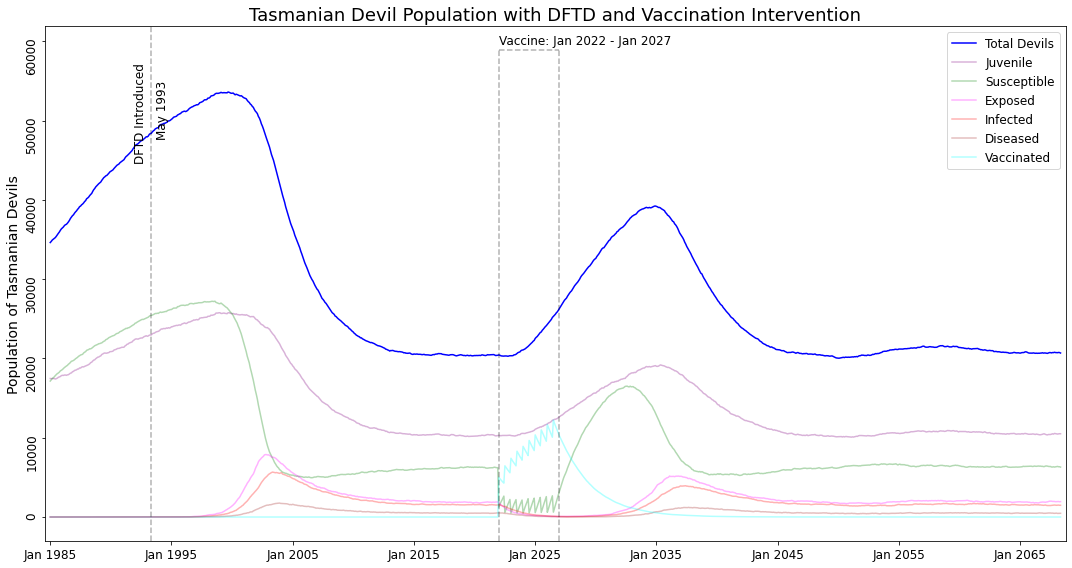

In [11]:
vacc_sim.plot()

### Parameter Sweep

In [12]:
params = [
    {"parameter": "vaccinated_infection_rate", "range": [0.1, 0.2, 0.4, 0.6]},
    {"parameter": "vaccination_proportion", "range": [0.6, 0.8, 1.0]},
    {"parameter": "vacc_program_length", "range": [3, 5, 6, 7, 8, 9, 10, 11,]},
    {"parameter": "vaccine_frequency", "range": [2, 4, 6]}
]

In [13]:
%time vacc_job.run(solver=vacc_sol, params=params)

Running 0 new parameter points in 0 batches with 150 points per batch
Estimated time to completion per batch: 0.0 hrs 0.0 mins 0 secs
Total estimated time to completion: 0.0 hrs 0.0 mins 0 secs
CPU times: user 748 µs, sys: 943 µs, total: 1.69 ms
Wall time: 1.55 ms


### Visualize Parameter Sweep Results

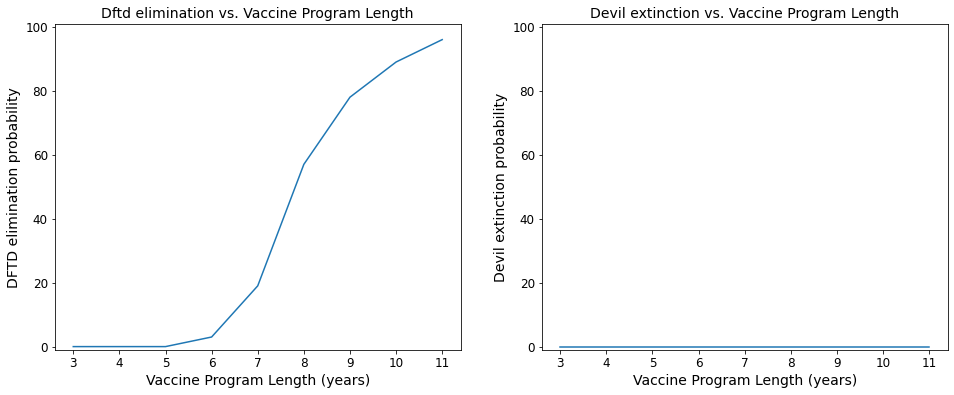

In [14]:
res_sub_keys=["vaccine_frequency:6", "vaccination_proportion:0.8", "vaccinated_infection_rate:0.6"]
vacc_job.plot_devil_dftd_extinction_over_param(
    res_sub_keys=res_sub_keys, key="vacc_program_length", param_label="Vaccine Program Length", units="years"
)

In [15]:
vacc_job.explore_results()

Output()

### Store Vaccination State

In [16]:
vacc_state = {"model": vacc_model, "sim":vacc_sim, "job":vacc_job}
with open(vacc_state_path, "wb") as vacc_state_file:
    pickle.dump(vacc_state, vacc_state_file)

In [17]:
def get_parameters(job):
    parameters = []
    for param in job.params:
        parameters.append({
            'name': param['parameter'],
            'range': param['range']
        })
    return parameters

In [18]:
def get_probs(job):
    eliminations = {}
    extinctions = {}
    for key, sim in job.results.items():
        eliminations[key] = sim.dftd_elimination
        extinctions[key] = sim.devil_extinction
    return eliminations, extinctions

In [19]:
def generate_prob_data_file(job, state_file):
    eliminations, extinctions = get_probs(job)
    data = {
        'parameters': get_parameters(job),
        'elimination_probs': eliminations,
        'extinction_probs': extinctions
    }
    
    dst = "../figure_data/Fig11A-C-data.json"
    with open(dst, "w") as data_file:
        json.dump(data, data_file, sort_keys=True, indent=4)

In [20]:
generate_prob_data_file(vacc_job, vacc_state_path)

## Clean Up Solver Files

In [21]:
cleanup_tempfiles()

In [22]:
c.close() # close the dask client